## `meteocre.fetchhrrr` Demo Notebook

### Prerequisites
[ Download directory already setup ]

### What are HRRR Products?
[ Some high level here ]

### Product Types
- 3D Pressure Levels
- Native Levels
- 2D Surface Levels
- 2D Surface Levels (Subhourly) :warning: Limited support!

### Outline
1. Fetch HRRR product for date / time / product ID
   - Inspect date / time / product id / version
2. Working with inventory
   - How it works
   - Links to inventory data
   - Get Product by Index
   - Get Product by Parameter
3. Working with data (visualizations!)
   - Map projections
   - GDAL dataset
   - Numpy Array
   - To GeoTIFF
4. Query raster at specific points
   - Single points
   - All points within radius
5. Mesoanalysis
   - Supercell Composite Parameter
   - Significant Tornado Parameter

In [27]:
from pprint import pprint
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pytz

from meteocre.fetchhrrr import HRRRProduct
from meteocre.fetchhrrr.visualize.nws_standard_colormaps import cm_dpt, cm_temp, cm_wind

In [2]:

# Request a HRRR surface product for May 1st, 2018; 18Z run, +6 hours forecast
run_time = datetime(2018, 5, 1, 18, 0, 0, tzinfo=pytz.UTC)
forecast_hour = 6
product_id = 'sfc'

# Request the product from the archive
# Notice we don't actually fetch the product here, since we're not using
# it! Instead we are just referencing its metadata
product = HRRRProduct.from_archive(run_time, forecast_hour, product_id)

# Inspect the product results
print('Product run time:', product.run_time)
print('Product forecast time:', product.forecast_time)
print('Product type:', product.product_name)
print('Product version: HRRRv%d' % product.product_version)

Product run time: 2018-05-01 18:00:00+00:00
Product forecast time: 2018-05-02 00:00:00+00:00
Product type: 2D Surface Levels
Product version: HRRRv2


In [7]:
# Request a product by parameter
# Perhaps I want all ones called "TEMP" (temperature)
print('List of temperature products:')
pprint(product.inventory.get_product_by_param('TMP'))
print()



List of temperature products:
[{'desc': 'Temperature [C]',
  'idx': 12,
  'level': '50000-ISBL',
  'level_desc': '500 mb',
  'level_tech_desc': '50000[Pa] ISBL="Isobaric surface"',
  'param': 'TMP'},
 {'desc': 'Temperature [C]',
  'idx': 17,
  'level': '70000-ISBL',
  'level_desc': '700 mb',
  'level_tech_desc': '70000[Pa] ISBL="Isobaric surface"',
  'param': 'TMP'},
 {'desc': 'Temperature [C]',
  'idx': 22,
  'level': '85000-ISBL',
  'level_desc': '850 mb',
  'level_tech_desc': '85000[Pa] ISBL="Isobaric surface"',
  'param': 'TMP'},
 {'desc': 'Temperature [C]',
  'idx': 26,
  'level': '92500-ISBL',
  'level_desc': '925 mb',
  'level_tech_desc': '92500[Pa] ISBL="Isobaric surface"',
  'param': 'TMP'},
 {'desc': 'Temperature [C]',
  'idx': 30,
  'level': '100000-ISBL',
  'level_desc': '',
  'level_tech_desc': '100000[Pa] ISBL="Isobaric surface"',
  'param': 'TMP'},
 {'desc': 'Temperature [C]',
  'idx': 47,
  'level': '0-SFC',
  'level_desc': 'surface',
  'level_tech_desc': '0[-] SFC="Gro

In [8]:
print('700mb Temperature Product:')
pprint(product.inventory.get_product_by_param('TMP', levels=['70000-ISBL'])[0])
print()

print('2-meter Dewpoint Product:')
pprint(product.inventory.get_product_by_param('DPT', levels=['2-HTGL'])[0])
print()

700mb Temperature Product:
{'desc': 'Temperature [C]',
 'idx': 17,
 'level': '70000-ISBL',
 'level_desc': '700 mb',
 'level_tech_desc': '70000[Pa] ISBL="Isobaric surface"',
 'param': 'TMP'}

2-meter Dewpoint Product:
{'desc': 'Dew point temperature [C]',
 'idx': 57,
 'level': '2-HTGL',
 'level_desc': '2 m above ground',
 'level_tech_desc': '2[m] HTGL="Specified height level above ground"',
 'param': 'DPT'}



In [4]:
# NOTE: order not guaranteed!
print('2-meter Temperature & Dewpoint Products:')
pprint(product.inventory.get_product_by_param(['TMP', 'DPT'], levels=['2-HTGL']))
print()

2-meter Temperature & Dewpoint Products:
[{'desc': 'Temperature [C]',
  'idx': 54,
  'level': '2-HTGL',
  'level_desc': '2 m above ground',
  'level_tech_desc': '2[m] HTGL="Specified height level above ground"',
  'param': 'TMP'},
 {'desc': 'Dew point temperature [C]',
  'idx': 57,
  'level': '2-HTGL',
  'level_desc': '2 m above ground',
  'level_tech_desc': '2[m] HTGL="Specified height level above ground"',
  'param': 'DPT'}]



In [26]:
# Get index for 2-meter temperature & dewpoint, as well as composite reflectivity
tmp_idx = product.inventory.get_product_by_param('TMP', levels=['2-HTGL'])[0]['idx']
dpt_idx = product.inventory.get_product_by_param('DPT', levels=['2-HTGL'])[0]['idx']
ref_idx = product.inventory.get_product_by_param('REFC')[0]['idx']
uwind_idx = product.inventory.get_product_by_param('UGRD', levels=['85000-ISBL'])[0]['idx']
vwind_idx = product.inventory.get_product_by_param('VGRD', levels=['85000-ISBL'])[0]['idx']

print('Temperature product index is:', tmp_idx)
print('Dewpoint product index is:', dpt_idx)
print('Composite reflectivity index is:', ref_idx)
print('U/V Wind Component (at 850mb) indices: (%d, %d)' % (uwind_idx, vwind_idx))

Temperature product index is: 54
Dewpoint product index is: 57
Composite reflectivity index is: 1
U/V Wind Component (at 850mb) indices: (24, 25)


0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 280P x 133L.
0...10...20...30...40...50...60...70...80...90...100 - done.


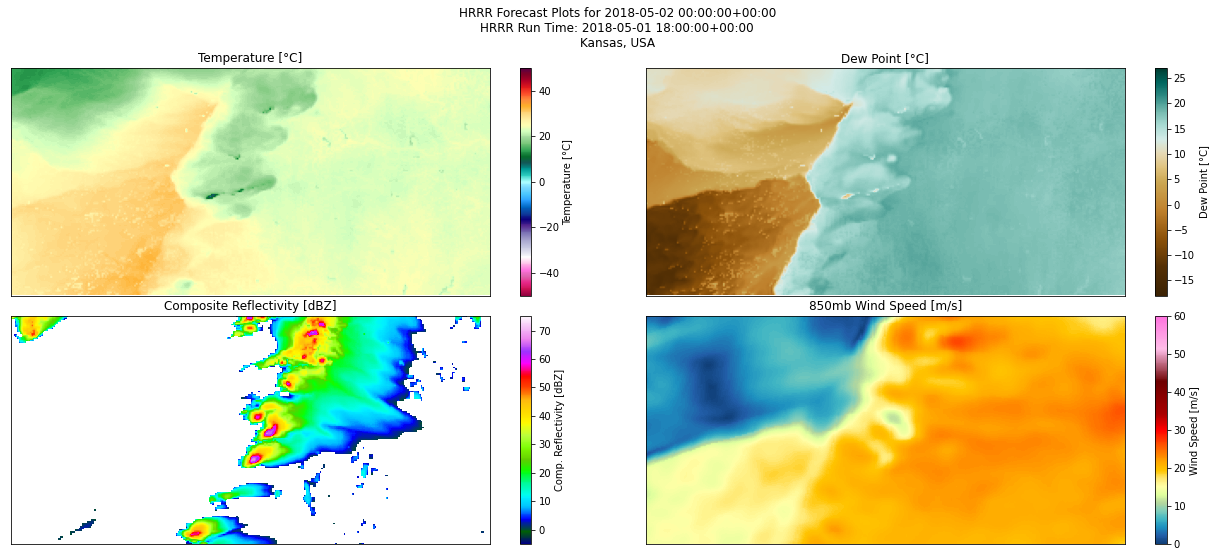

In [48]:
ds = product.get_ds_for_product_idx([dpt_idx, tmp_idx, ref_idx, uwind_idx, vwind_idx], proj='world', bounds=(-102.552, 36.493, -94.088, 40.503))
im_dpt = ds.GetRasterBand(1).ReadAsArray()
im_tmp = ds.GetRasterBand(2).ReadAsArray()
im_ref = ds.GetRasterBand(3).ReadAsArray()
im_ref[im_ref < 0] = np.nan

im_uwind = ds.GetRasterBand(4).ReadAsArray()
im_vwind = ds.GetRasterBand(5).ReadAsArray()
im_wind = np.sqrt(np.square(im_uwind) + np.square(im_vwind))

ds = None

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 8))
fig.tight_layout(rect=(0, 0, 1, 0.9))
fig.suptitle('HRRR Forecast Plots for %s\nHRRR Run Time: %s\nKansas, USA' % (product.forecast_time, product.run_time))
ax = ax.flatten()  # type: ignore
im1 = ax[0].imshow(im_tmp, **cm_temp())
ax[0].set_title('Temperature [\u00B0C]')
im2 = ax[1].imshow(im_dpt, **cm_dpt())
ax[1].set_title('Dew Point [\u00B0C]')
im3 = ax[2].imshow(im_ref, cmap='gist_ncar', vmin=-5, vmax=75)
ax[2].set_title('Composite Reflectivity [dBZ]')
im4 = ax[3].imshow(im_wind, **cm_wind())
ax[3].set_title('850mb Wind Speed [m/s]')
for _ax in ax:
    _ax.get_xaxis().set_visible(False)
    _ax.get_yaxis().set_visible(False)
plt.colorbar(im1, ax=ax[0], label='Temperature [\u00B0C]')
plt.colorbar(im2, ax=ax[1], label='Dew Point [\u00B0C]')
plt.colorbar(im3, ax=ax[2], label='Comp. Reflectivity [dBZ]')
plt.colorbar(im4, ax=ax[3], label='Wind Speed [m/s]')
plt.show()